In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from sprintdl.main import *

In [3]:
device = torch.device('cuda',0)
from torch.nn import init
import torch
import math

# Define required

In [4]:
# x_train,y_train,x_valid,y_valid = get_mnist("/media/hdd/Datasets/imagenette2-160.tgz")

In [5]:
fpath = Path("/media/hdd/Datasets/imagenette2-160/")

tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs = 256

In [6]:
il = ImageList.from_files(fpath, tfms=tfms)

In [7]:
il

ImageList (13394 items)
[PosixPath('/media/hdd/Datasets/imagenette2-160/train/n03394916/n03394916_17985.JPEG'), PosixPath('/media/hdd/Datasets/imagenette2-160/train/n03394916/n03394916_42703.JPEG'), PosixPath('/media/hdd/Datasets/imagenette2-160/train/n03394916/n03394916_38263.JPEG'), PosixPath('/media/hdd/Datasets/imagenette2-160/train/n03394916/n03394916_47924.JPEG'), PosixPath('/media/hdd/Datasets/imagenette2-160/train/n03394916/n03394916_21327.JPEG'), PosixPath('/media/hdd/Datasets/imagenette2-160/train/n03394916/n03394916_29698.JPEG'), PosixPath('/media/hdd/Datasets/imagenette2-160/train/n03394916/n03394916_30099.JPEG'), PosixPath('/media/hdd/Datasets/imagenette2-160/train/n03394916/n03394916_28717.JPEG'), PosixPath('/media/hdd/Datasets/imagenette2-160/train/n03394916/n03394916_6976.JPEG'), PosixPath('/media/hdd/Datasets/imagenette2-160/train/n03394916/n03394916_33083.JPEG')...]
Path: /media/hdd/Datasets/imagenette2-160

In [8]:
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [9]:
ll

SplitData
Train: LabeledData
x: ImageList (9469 items)
[PosixPath('/media/hdd/Datasets/imagenette2-160/train/n03394916/n03394916_17985.JPEG'), PosixPath('/media/hdd/Datasets/imagenette2-160/train/n03394916/n03394916_42703.JPEG'), PosixPath('/media/hdd/Datasets/imagenette2-160/train/n03394916/n03394916_38263.JPEG'), PosixPath('/media/hdd/Datasets/imagenette2-160/train/n03394916/n03394916_47924.JPEG'), PosixPath('/media/hdd/Datasets/imagenette2-160/train/n03394916/n03394916_21327.JPEG'), PosixPath('/media/hdd/Datasets/imagenette2-160/train/n03394916/n03394916_29698.JPEG'), PosixPath('/media/hdd/Datasets/imagenette2-160/train/n03394916/n03394916_30099.JPEG'), PosixPath('/media/hdd/Datasets/imagenette2-160/train/n03394916/n03394916_28717.JPEG'), PosixPath('/media/hdd/Datasets/imagenette2-160/train/n03394916/n03394916_6976.JPEG'), PosixPath('/media/hdd/Datasets/imagenette2-160/train/n03394916/n03394916_33083.JPEG')...]
Path: /media/hdd/Datasets/imagenette2-160
y:ItemList (9469 items)
[0, 0,

In [10]:
data = ll.to_databunch(bs, c_in=3, c_out=10)

# Training

# Define model and data

In [11]:
def prev_pow_2(x): return 2**math.floor(math.log2(x))

def get_cnn_layers(data, nfs, layer, **kwargs):
    def f(ni, nf, stride=2): return layer(ni, nf, 3, stride=stride, **kwargs)
    l1 = data.c_in
    l2 = prev_pow_2(l1*3*3)
    layers =  [f(l1  , l2  , stride=1),
               f(l2  , l2*2, stride=2),
               f(l2*2, l2*4, stride=2)]
    nfs = [l2*4] + nfs
    layers += [f(nfs[i], nfs[i+1]) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), Lambda(flatten), 
               nn.Linear(nfs[-1], data.c_out)]
    return layers

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

def get_learner(nfs, data, lr, layer, loss_func=F.cross_entropy,
                cb_funcs=None, opt_func=sgd_opt, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return Learner(model, data, loss_func, lr=lr, cb_funcs=cb_funcs, opt_func=opt_func)

In [20]:
nfs = [64,64,128,256]
# sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 
sched = combine_scheds([0.3, 0.7], [sched_cos(.1,.3), sched_cos(.3, 0.05)])
# mnist_view = view_tfm(1,28,28)

cbfs = [
    partial(AvgStatsCallback,accuracy),
    partial(ParamScheduler, 'lr', sched),
        partial(BatchTransformXCallback, norm_imagenette),
    ProgressCallback,
    Recorder,
       partial(CudaCallback, device)]

epochs = 5
lr = .001
# opt_func = partial(sgd_mom_opt, wd=0.01)
# opt_func = adam_opt()
opt_func = lamb

In [21]:
learn = get_learner(nfs, data, lr, conv_layer, cb_funcs=cbfs)

In [22]:
# model_summary(learn, data)

In [23]:
learn.fit(epochs)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.248817,0.166015,2.178141,0.197707,00:08
1,2.184563,0.208892,2.198461,0.128662,00:08
2,2.208593,0.184919,2.172632,0.220127,00:08
3,2.040847,0.284085,1.970880,0.302166,00:08
4,1.859408,0.354842,1.847938,0.355669,00:08


epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.233422,0.167705,2.270912,0.164331,00:31


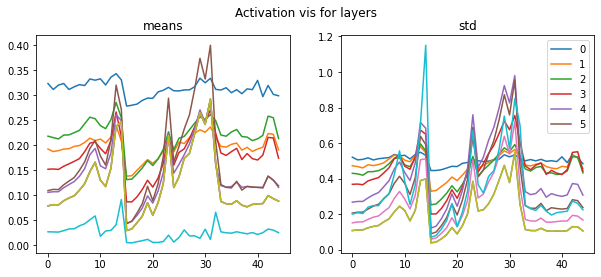

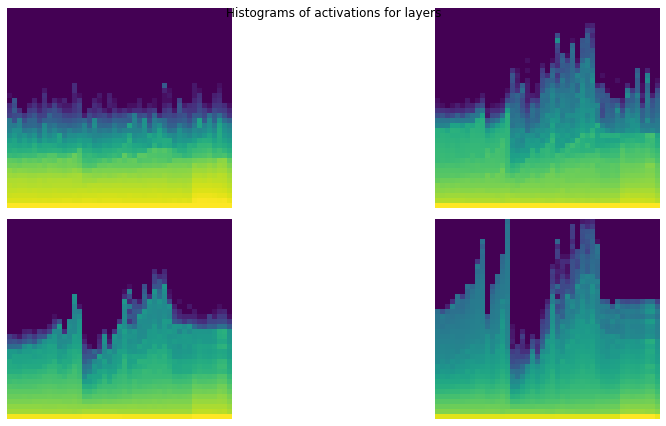

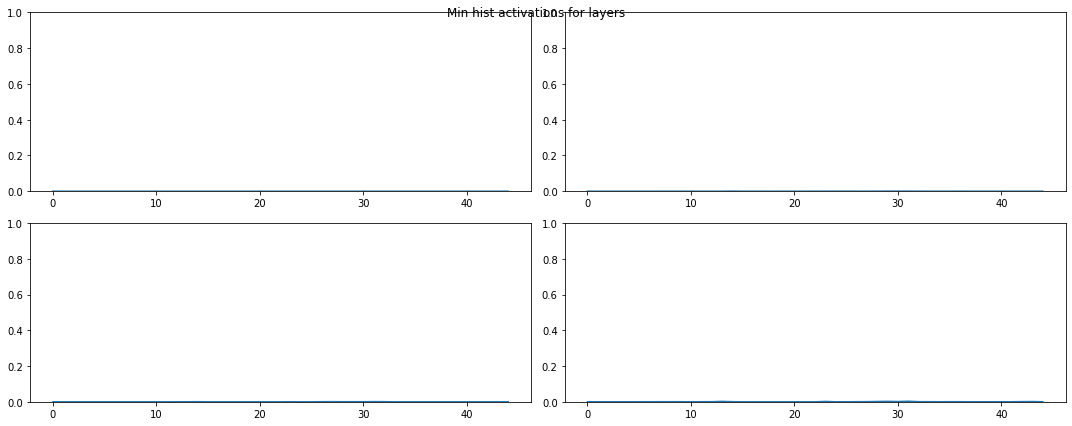

In [16]:
run_with_act_vis(epochs,learn)

# Digging in

In [17]:
learn.avg_stats.valid_stats.avg_stats

[2.270911624203822, tensor(0.1643, device='cuda:0')]

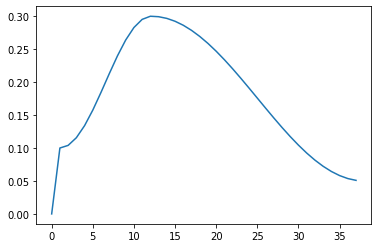

In [18]:
learn.recorder.plot_lr()

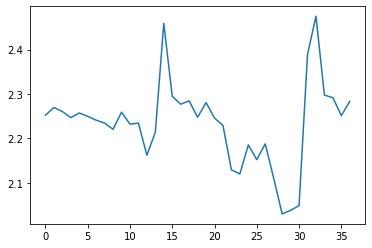

In [19]:
learn.recorder.plot_loss()